In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from decision_tree import DecisionTree
from graphviz import Digraph
from dataset import Dataset

In [2]:
TRAIN_DATA_PATH = "data/ann-train.data"
TEST_DATA_PATH = "data/ann-test.data"
COST_DATA_PATH = "data/ann-thyroid.cost"

dataset = Dataset(TRAIN_DATA_PATH, TEST_DATA_PATH, COST_DATA_PATH)
train_sample_count = dataset.train_data.to_numpy().shape[0]
test_sample_count = dataset.test_data.to_numpy().shape[0]
print("Dataset Loaded: There are {} training samples and {} test samples in the dataset".format(train_sample_count, test_sample_count))

Dataset Loaded: There are 3772 training samples and 3428 test samples in the dataset


In [3]:
# Converting data samples to usable format 
train_data = dataset.train_data.to_numpy()
test_data = dataset.test_data.to_numpy()
print("Shape of training data: {}".format(train_data.shape))
print("Shape of test data: {}".format(test_data.shape))

Shape of training data: (3772, 22)
Shape of test data: (3428, 22)


To observe the output of the class implemented initially a classifier is implemented without any optimized hyperparameters. The sample confusion matrix is given as follows

In [4]:
# Evaluating model
classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure="entropy", prune_length=5, use_cost=False)

In [5]:
confusion_matrix = classifier.evaluate_model()
confusion_matrix

array([[  69,    0,    4],
       [   0,  177,    0],
       [   8,   11, 3159]])

For the initial classifier, confusion matrix for the test set is as follows:

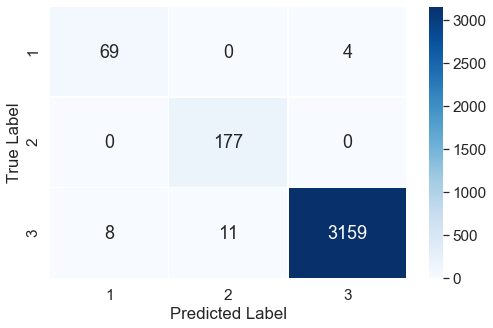

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt
def plot_matrix(confusion_matrix):
    matrix_df = pd.DataFrame(confusion_matrix, index=["1", "2", "3"], columns=["1", "2", "3"])
    matrix_df.index.name = "True Label"
    matrix_df.columns.name = "Predicted Label"
    plt.figure(figsize = (8,5))
    sn.set(font_scale=1.4)
    sn.heatmap(matrix_df,annot=True, fmt="d", linewidths=.5, annot_kws={"size": 18}, cmap="Blues")
plot_matrix(confusion_matrix)

In [7]:
# Reporting Accuracies
def evaluate_matrix(matrix):
    assert matrix.shape[0] == matrix.shape[1]
    no_of_classes = matrix.shape[0]
    overall_acc = sum([matrix[i, i] for i in range(matrix.shape[0])]) / np.sum(matrix)
    accuracies = []
    for class_no in range(matrix.shape[0]):
        if np.sum(matrix[class_no, :]) == 0:
            acc = 0
        else:
            acc = matrix[class_no, class_no] / np.sum(matrix[class_no, :])
        accuracies.append(acc)
    return overall_acc, accuracies
evaluate_matrix(confusion_matrix)

(0.9932905484247374, [0.9452054794520548, 1.0, 0.9940213971050975])

To find optimal parameters for the classifier, grid search approach is implemented with the following method. Then the best parameters found are reported in the order of Best aacuracy, impurity measure, prune length and information gain threshold: 

In [8]:
def find_best_params():
    possible_measures = {"entropy", "gini"}
    possible_prunes = list(range(0, 10))
    possible_prunes.append(None)
    impurity_limit = [0, 0.01, 0.003, 0.1, 0.3, 0.5, 0.8, 1.0]
    classes, counts = np.unique(test_data[:,-1], return_counts=True)
    weights = np.array([counts[1] * counts[2], counts[0] * counts[2], counts[1] * counts[0]])
    weights = weights / np.sum(weights)
    best_acc = 0
    best_measure = None
    best_prune = None
    best_limit = None
    for measure in possible_measures:
        for prune in possible_prunes:
            for limit in impurity_limit:
                classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure=measure, prune_length=prune, prune_threshold=limit, use_cost=False)
                matrix = classifier.evaluate_model()
                acc_values = evaluate_matrix(matrix)[1]
                acc = np.sum(weights * acc_values)
                if acc > best_acc:
                    best_acc = acc
                    best_measure = measure
                    best_prune = prune
                    best_limit = limit
        return best_acc, best_measure, best_prune, best_limit
best_params = find_best_params()
best_params
            

(0.9998892191039116, 'entropy', 5, 0.1)

According to the optimal parameters, the trained classifier evaluated. The results for the test set is given in the form of a confusion matrix and accuracy values are given as follows

Overall Accuracy: 0.9935822637106184
Class 1 Accuracy: 1.0
Class 1 Accuracy: 1.0
Class 1 Accuracy: 0.9930774071743235


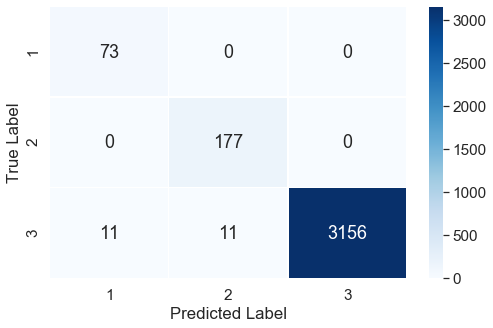

In [9]:
classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure=best_params[1], prune_length=best_params[2], prune_threshold=best_params[3], use_cost=False)
confusion_matrix = classifier.evaluate_model()
results = evaluate_matrix(confusion_matrix)
print("Overall Accuracy: {}".format(results[0]))
print("Class 1 Accuracy: {}".format(results[1][0]))
print("Class 1 Accuracy: {}".format(results[1][1]))
print("Class 1 Accuracy: {}".format(results[1][2]))
plot_matrix(confusion_matrix)

Finally, the decision tree with the optimal hyperparameters is plotted by using graphviz library.

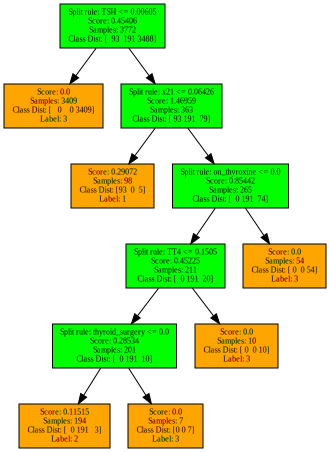

In [11]:
class TreePlot():
    def __init__(self):
        self.last_node = 0
        self.graph = None

def get_node_text(node):
    node_text = ""
    if node.left_child == None or node.right_child == None: # Leaf Node
        node_text += "Score: {}\n".format(node.score)
        node_text += "Samples: {}\n".format(np.sum(node.class_dist))
        node_text += "Class Dist: {}\n".format(node.class_dist)
        node_text += "Label: {}".format(node.label)
    else:
        node_text += "Split rule: {} <= {}\n".format(classifier.features[node.feature_idx], node.threshold)
        node_text += "Score: {}\n".format(node.score)
        node_text += "Samples: {}\n".format(np.sum(node.class_dist))
        node_text += "Class Dist: {}\n".format(node.class_dist)
    return node_text
        

def plot_tree(classifier):
    plot = TreePlot()
    plot.graph = Digraph(name="part2", format="png", filename="part2.gv")
    classifier.root.score = round(classifier.root.score, 5)
    classifier.root.threshold = round(classifier.root.threshold, 5)
    node_text = get_node_text(classifier.root)
    plot.last_node += 1
    plot.graph.attr("node", shape="box")
    plot.graph.node("node_" + str(plot.last_node), label=node_text, style="filled", fillcolor="green", fontsize="8")
    node_no = plot.last_node
    traverse_tree(plot, classifier.root.left_child, node_no)
    traverse_tree(plot, classifier.root.right_child, node_no)
    return plot.graph

def traverse_tree(plot, node, parent_no):
    if (node.left_child == None) or (node.right_child == None): # Leaf Node
        if node.score == -0.0:
            node.score = 0.0
        else:
            node.score = round(node.score, 5)
        node_text = get_node_text(node)
        plot.last_node += 1
        plot.graph.attr("node", shape="box", fillcolor="blue")
        plot.graph.node("node_" + str(plot.last_node), label=node_text, style="filled", fillcolor="orange",fontsize="8")
        plot.graph.edge("node_" + str(parent_no), "node_" + str(plot.last_node))
        return
    node.threshold = round(node.threshold, 5)
    node.score = round(node.score, 5)
    node_text = get_node_text(node)
    plot.last_node += 1
    plot.graph.attr("node", shape="box")
    plot.graph.node("node_" + str(plot.last_node), label=node_text, style="filled",fillcolor="green", fontsize="8")
    plot.graph.edge("node_" + str(parent_no), "node_" + str(plot.last_node))
    node_no = plot.last_node
    traverse_tree(plot, node.left_child, node_no)
    traverse_tree(plot, node.right_child, node_no)
graph = plot_tree(classifier)
graph.view()
graph

To see whether the training data overfits the decision tree, the confusion matrix is plotted. This decision matrix is the proof that the model with optimal hyperparameters is a good model. The class based accuracies and the confusion matrix for the **training set** for the **best classifier** is given below:

Overall Accuracy: 0.9978791092258749
Class 1 Accuracy: 1.0
Class 1 Accuracy: 1.0
Class 1 Accuracy: 0.9977064220183486


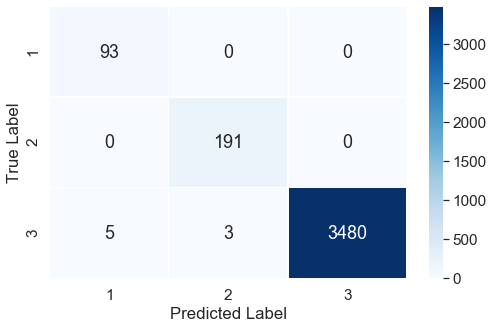

In [15]:
def evaluate_train_set(train_set, classifier):
    confusion_matrix = np.zeros((3,3), dtype=int)
    for sample_idx in range(train_set.shape[0]):
        sample = train_set[sample_idx,:]
        label = classifier.test_sample(sample)
        confusion_matrix[int(sample[-1]) - 1, label - 1] += 1
    return confusion_matrix
train_matrix = evaluate_train_set(train_data, classifier)
acc_values = evaluate_matrix(train_matrix)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 1 Accuracy: {}".format(acc_values[1][1]))
print("Class 1 Accuracy: {}".format(acc_values[1][2]))
plot_matrix(train_matrix)

Finally, to see the base model classifier, the visualization of the fully grown tree is provided below:

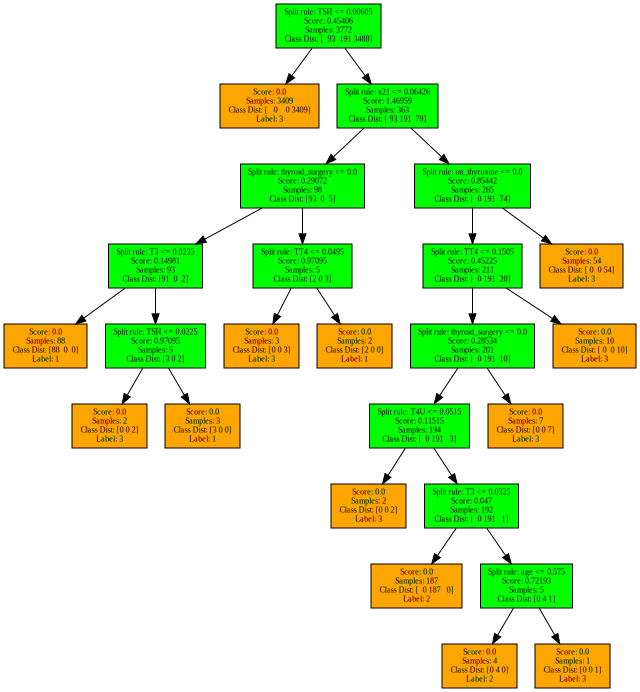

In [17]:
classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure="entropy", prune_length=None, use_cost=False)
graph_base = plot_tree(classifier)
graph_base